In [1]:
import numpy as np
from datasets import load_from_disk
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
import os
os.environ["HF_DATASETS_CACHE"]="/shared/.cache/huggingface/dataset"

In [2]:
from utils.dataset import setup_data
dataset = setup_data('/shared/cmu', ds_seed=43)
#datasets = load_from_disk('/job_workspace/how2_all_proc_10p') #Just filtered Velocity

Loading dataset from disk:   0%|          | 0/48 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Labels', 'COVAREP', 'FACET', 'OpenFace', 'glove_vectors'],
        num_rows: 20923
    })
    test: Dataset({
        features: ['Labels', 'COVAREP', 'FACET', 'OpenFace', 'glove_vectors'],
        num_rows: 2325
    })
})

In [4]:
!ls training_output_05_21_23_02_2024_2_i

ls: cannot access 'training_output_05_21_23_02_2024_2_i': No such file or directory


In [12]:
#epoch = 50
output_dirs={
    #'z0': 'training_output_05_21_23_02_2024_2',
    #'m0': 'training_output_03_00_22_02_2024',
    #'j0': ''
}
embeddings={
    'j2': 'training_output_01_27_27_02_2024_2', #pious-firefly-111
    'j0': 'training_output_01_31_27_02_2024_1', #cool-dust-112
    'j1': 'training_output_23_50_26_02_2024_2', #astral-elevator-110
    'z0': 'training_output_21_00_26_02_2024_4',
    'm0': 'training_output_23_08_26_02_2024_2',
}

embeddings={
    'j2': 'training_output_01_27_27_02_2024_2_i30', #pious-firefly-111
    'j0': 'training_output_01_31_27_02_2024_1_i30', #cool-dust-112
    'j1': 'training_output_23_50_26_02_2024_2_i30', #astral-elevator-110
    'z0': 'training_output_21_00_26_02_2024_4_i30',
    'm0': 'training_output_23_08_26_02_2024_2_i30',
}

In [13]:
#TBD
from torch import nn
def compute_cosines(embedding, embeddings):
    #for k,v in embeddings.items():
    cos0 = torch.nn.CosineSimilarity(dim=1)
    return cos0(embedding.unsqueeze(0).repeat(embeddings.shape[0],1), embeddings)
def get_rank(x, indices):
    vals = x[range(len(x)), indices]
    return (x > vals[:, None]).long().sum(1)

In [14]:
import torch
test = 'm0'
e_train=torch.load(f'../{embeddings[test]}/train_embeddings.pt', map_location="cpu")
m_train=torch.load(f'../{embeddings[test]}/train_masks.pt', map_location="cpu")
s_train=torch.load(f'../{embeddings[test]}/train_labels.pt', map_location="cpu").squeeze()

e_test=torch.load(f'../{embeddings[test]}/eval_embeddings.pt', map_location="cpu")
m_test=torch.load(f'../{embeddings[test]}/eval_masks.pt', map_location="cpu")
s_test=torch.load(f'../{embeddings[test]}/eval_labels.pt', map_location="cpu").squeeze()

print(e_train['COVAREP'].shape)
print(e_test["COVAREP"].shape)
print(s_test.shape)

torch.Size([20920, 512])
torch.Size([2320, 512])
torch.Size([2320, 7])


In [15]:
s_test.shape

torch.Size([2320, 7])

In [16]:
from torch.utils.data import Dataset
class FineTuneDataset(Dataset):
    def __init__(self, embeddings, labels, key='fusion',index = 0,transform=None, target_transform=None):
        #self.embeddings = torch.cat([embeddings[k] for k in embeddings.keys()],dim=1)
        self.embeddings = embeddings[key]
        self.labels = labels[:,index] #First is a sentiment [-3,3] -3: negative 3:postive, next is 6 labels for emotions [0,3] where 3 is strong and 0 is no x and 3 is strong x
        print(f"{self.labels.shape = }")
        if index > 0:
            self.labels = self.labels/3.0
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [17]:
!pip install --upgrade torchmetrics

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [18]:
# Import the W&B Python Library
import wandb
from tqdm import tqdm
from torchmetrics import PearsonCorrCoef
#from torchmetrics import F1Score
# 1. Start a W&B Run
run = wandb.init(
    project="CMU_Inference",
    name = 'm0',
)
train_dataloader = torch.utils.data.DataLoader(FineTuneDataset(e_train,s_train, index=0), batch_size=1024, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(FineTuneDataset(e_test,s_test, index=0), batch_size=1024)
print(next(iter(train_dataloader))[0].shape)
num_emb = next(iter(train_dataloader))[0].shape[1]
model = nn.Linear(num_emb,1)
#model = nn.Sequential(nn.Linear(num_emb,256),nn.Dropout(0.1),nn.ReLU(),nn.Linear(256,1))
#model = nn.Sequential(nn.Linear(512,1),nn.Sigmoid())
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000001) # * world_size)
#loss_fn = torch.nn.L1Loss()
loss_fn = torch.nn.L1Loss() 
#loss_fn=torch.nn.BCEWithLogitsLoss()

model.train()
train_len = len(train_dataloader)
test_len = len(test_dataloader)
print(f"{train_len = } {test_len = }")
num_epochs=2048*10
pbar = tqdm(range(num_epochs))
met = PearsonCorrCoef()
#met = BinaryF1Score()
for epoch in pbar:
    epoch_loss_train = torch.Tensor([0.0])
    model.train()
    for batch in train_dataloader:
        embedding,label = batch
        pred = model(embedding).squeeze()
        loss = loss_fn(pred,label)
        loss.backward()
        optimizer.step()
        epoch_loss_train += loss.detach().cpu()
        met.update(pred,label)
        #met.update(pred,(label>0.5).to(torch.int))
    train_met = met.compute()
    met.reset()
    model.eval()
    with torch.no_grad():
        epoch_loss_eval = torch.Tensor([0.0])
        for batch in test_dataloader:
            embedding,label = batch
            pred = model(embedding).squeeze()
            loss = loss_fn(pred,label)
            epoch_loss_eval += loss.detach().cpu()
            #met.update(pred,(label>0.5).to(torch.int))
            met.update(pred,label)
        val_met = met.compute()
        met.reset()
    pbar.set_description(f"{epoch_loss_eval/float(test_len)}")
    wandb.log({'train_loss': epoch_loss_train/float(train_len), 
               'val_loss': epoch_loss_eval/float(test_len), 
               'train_met':train_met,
               'val_met':val_met})


train_loss,█▆▄▃▃▂▂▁▁▂▂▂▂▂▂▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_met,▁▅▆▇▇▇██████████████████████████████████
val_loss,█▆▄▃▂▂▁▁▁▁▁▁▂▂▃▃▃▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
val_met,▁▅▆▇▇▇████████████▇▇▇▇▇▇▇▇▇█████████████
train_loss,0.74491
train_met,0.48084
val_loss,0.75701
val_met,0.47457


self.labels.shape = torch.Size([20920])
self.labels.shape = torch.Size([2320])
torch.Size([1024, 512])
train_len = 21 test_len = 3


tensor([0.7654]): 100%|█████████████████████████████████████████████████████████| 20480/20480 [46:53<00:00,  7.28it/s]


In [ ]:
def rank_metrics(embeddings, masks, modality, fusion="fusion"):
    c=list()
    xc=list()
    idx = list()
    batch_size = e[modality].shape[0]
    #print(e[modality].shape)
    for i in range(batch_size):
        mx=m[modality][i]
        if not mx:
            pass
        idx.append(i)
        x=e[modality][i,:] #.shape
        #xx=e['pt']
        #xc.append(compute_recall(x,xx).topk(10))
        y=e[fusion]#.shape
        c.append(compute_cosines(x,y))
        #print(c[i].topk(25))
        #_=plt.hist(c.cpu(), bins=1000, log=True)
    ranks = get_rank(torch.stack(c), torch.tensor(idx))
    median_rank = ranks.median()
    r1 = sum(ranks == 0)/len(ranks)
    r5 = sum(ranks < 5)/len(ranks)
    r10 = sum(ranks < 10)/len(ranks)
    return median_rank, r1, r5, r10

In [ ]:
from collections import defaultdict
modalities = ['COVAREP',"FACET","OpenFace","glove_vectors"]
data = defaultdict(list)
header = []
for k,v in embeddings.items():
    e=torch.load(f'../{v}/eval_embeddings.pt', map_location="cpu")
    m=torch.load(f'../{v}/eval_masks.pt', map_location="cpu")
    header.append(k)
    for k2 in modalities:
        x=[x.cpu().item() for x in rank_metrics(e,m,k2)]
        print(f"{k}-{k2}-{x}")
        data[k2]+=x

In [9]:
def dict2ltxtab(d: dict, bare=False, headrow = None):
    if not bare:
        print(r"\begin{center}")
        print(r"\begin{tabular}{|c|c|}")
        print(r"\hline")
    if headrow and len(headrow) >= 2:
        print(headrow[0], "&", headrow[1], r"\\")
        print(r"\hline")
    for k, v in d.items():
        print(k, "&", v, r"\\")
    if not bare:
        print(r"\hline")
        print(r"\end{tabular}")
        print(r"\end{center}")

In [10]:
print(ranks.float().cpu().median())
_ = plt.hist(ranks.cpu(), bins=100)

NameError: name 'ranks' is not defined

In [36]:
cos0 = torch.nn.CosineSimilarity(dim=1)
output0 = cos0(torch.ones([3,10]), torch.ones([3,10]))
output0

tensor([1.0000, 1.0000, 1.0000])

In [ ]:
!ls ../training_output_03_41_31_01_2024/

In [ ]:
from safetensors.torch import load_model
from model import MFDOOM
from encoders import MultimodalCollator
from torch.utils.data import DataLoader
from utils.config import training_config, get_model_config
output_dir = "/efs-private/multimodal/training_output_01_35_20_01_2024" #0.8 Doom
#output_dir = "/efs-private/multimodal/training_output_01_36_20_01_2024" #0.3 Doom
#output_dir = "/efs-private/multimodal/training_output_01_38_20_01_2024" #0.8 Zorro
#output_dir = "/efs-private/multimodal/training_output_01_37_20_01_2024" #0.3 Zorro
config = training_config(os.path.join(output_dir,'config.yaml'))
model_config = get_model_config(config)
model_config['batch_size']=4

In [ ]:
import model
from importlib import reload
reload(model)
from model import MFDOOM

In [ ]:
default_data_collator = MultimodalCollator(config.modality_config)
#dataloader2 = DataLoader(dataset.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)
dataloader = DataLoader(datasets['test'].with_format('torch'), 
                        shuffle=True, 
                        collate_fn=default_data_collator, 
                        batch_size=4,)

In [ ]:
import torch
model = MFDOOM(**model_config)

In [ ]:
import torch
from safetensors.torch import load_model
load_model(model,os.path.join(output_dir,'model.safetensors'))

In [ ]:
dl=iter(dataloader)
infer_model = model.eval()
#batch = [next(dl) for x in range(4)]
output = [infer_model(next(dl)) for _ in range(2)]

In [ ]:
def zero_modes(batch, modes_to_zero):
    for mode in modes_to_zero:
        print(mode)
        if mode == 'aud':
            batch[mode]['values'] = torch.ones_like(batch[mode]['values'])*-10000
        elif mode == 'vid':
            batch[mode]['attention_mask']=torch.ones_like(batch[mode]['attention_mask'])
        else:
            batch[mode]['attention_mask']=torch.ones_like(batch[mode]['attention_mask'])
    return batch

In [ ]:
from tqdm import tqdm
from collections import defaultdict
import copy
import random
output=defaultdict(list)
infer_model = model.eval()
dl = iter(dataloader)
#mode_sets = [('aud',),('sm',),('en',),('pt',),('vid',)]
mode_sets = [('aud','sm',), ('vid','aud',), ('sm','en','pt',)]
batches = []
with torch.no_grad():
    for i in tqdm(range(4)):
        batch = next(dl)
        batches.append(batch)
        #batch = {k: {k2: v2 for k2,v2 in v.items()} for k,v in batch.items()}
        output[('baseline',)].append(infer_model(batch))
        random.shuffle(mode_sets)
        for modes in mode_sets:
            mode_batch = copy.deepcopy(batch)
            output[modes].append(infer_model(zero_modes(mode_batch,modes)))
print(output)

In [ ]:
def refactor(outputs):
    out_dict = {k:[] for k in outputs[0]}
    for k in ["losses", "loss", "modality_sample_mask"]:
        out_dict.pop(k, None)
    for batch in outputs:
        for key in out_dict.keys():
            out_dict[key].append(batch[key])
    print(out_dict.keys())
    out_dict = {k:torch.cat(v) for k,v in out_dict.items()}
    return out_dict

In [ ]:
output_r = {k: refactor(v) for k,v in output.items()}

In [ ]:
output[('baseline',)][0]['aud']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cosines(output, output2=None, log=False, vmin=None, vmax=None, plot_diag=True):
    cos = torch.nn.CosineSimilarity(dim=0)
    mat_dict={}
    for k,v in output.items():
        l = v.shape[0]
        mat_dict[k]=np.zeros([l,l])
        v2 = output2[k] if output2 else output['fusion']
        for i in range(l):
            for j in range(l):
                #print(f"{i},{j},{cos(output.fusion[i],output.fusion[j])}")
                if log:
                    mat_dict[k][i,j]=np.log10(cos(v[i],v2[j]))
                else:
                    mat_dict[k][i,j]=cos(v[i],v2[j])

    f, ax = plt.subplots(len(mat_dict),2, figsize=(6,3*len(mat_dict)))
    for i,(k,mat) in enumerate(mat_dict.items()):
        #f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2))
        #plt.figure(figsize=(2,2))
        #ax1.title(k)
        ax1 = ax[i,0]
        im = ax1.imshow(mat, vmin=vmin, vmax=vmax)
        ax1.set_ylabel(k)
        f.colorbar(im,ax=ax1)
        if plot_diag:
            #plt.figure(figsize=(2,2))
            #plt.title(f"{k} diagonals")
            bins = np.linspace(0,1.0,100)
            ax2 = ax[i,1]
            ax2.hist(np.diagonal(mat), bins=bins, alpha=0.3,density=True)
            ax2.hist(mat.flatten(), bins=bins, alpha=0.3, density=True)
            ax2.set_ylim(0,50)
            ax2.set_xlim(0,1.0)
            ax2.annotate(str(np.mean((mat.sum(1)-np.diag(mat))/(mat.shape[1]-1))),
                        [0.1, 0.1])
            ax2.legend(["diag","all"])

        

In [ ]:
print(output_r.keys())

In [ ]:
k = mode_sets[0]
print(k)
plot_cosines(output_r[('baseline',)],output_r[k],vmin=0.99999) #

# Attention masking tests

In [ ]:
plt.imshow(model.pool_mask, aspect=100)
plt.colorbar()

In [ ]:
t=torch.load('../batch.pt', map_location=torch.device('cpu'))
p=torch.load('../padding_mask.pt', map_location=torch.device('cpu'))
a = torch.load('../attn_mask.pt', map_location=torch.device('cpu'))

In [ ]:
plt.plot(p[0,:])
plt.figure()
plt.plot(p[1,:])
plt.figure()
plt.plot(p[4,:])

In [ ]:
plt.imshow(a)

In [ ]:
print(t.isnan().reshape((-1,t.shape[1]*t.shape[2]))
      .shape)
plt.imshow(torch.cat([t.isnan()[i,:,:] for i in range(8)], dim=1))
plt.colorbar()

In [ ]:
plt.imshow(model.attn_mask)

In [ ]:
import torch
token_types = torch.tensor(list((
    *((0,) * 1024),
    *((1,) * 1024),
    *((2,) * 1024),
    *((3,) * 1024),
)), dtype=torch.long)

In [ ]:
token_types.shape

In [ ]:
from einops import rearrange, repeat

In [ ]:
token_types_attend_from = rearrange(token_types, 'i -> i 1')
token_types_attend_to = rearrange(token_types, 'j -> 1 j')

In [ ]:
zorro_mask = token_types_attend_from == token_types_attend_to

In [ ]:
zorro_mask = zorro_mask | (token_types_attend_from == 3)

In [ ]:
token_types
floom_mask = [token_types != i for i in range(-1,3)]
for idx, tokens in enumerate(floom_mask):
    print(idx)
    a = -256*4 + 256*idx
    b = -256*4 + 256*(idx+1)-1
    print(f"{a}:{b}")
    tokens[-256*4:] = False
    tokens[a:b]= True
floom_mask = repeat(floom_mask, 'i j -> (i i2) j', i2=256)
plt.imshow(floom_mask)#, aspect = 1000)

In [ ]:
import matplotlib.pyplot as plt
zorro_mask[token_types == 3] = floom_mask
plt.imshow(zorro_mask)

In [ ]:
ax = plt.subplot(1,1,1)
im = ax.imshow(attn_mask[3,:,:] * zorro_mask)
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [ ]:
torch.empty(0)

In [ ]:
batch

In [ ]:
return_token_types = (0,1,2,3,3,3,3,4)
return_token_types_tensor = torch.tensor(list(return_token_types))
max_return_tokens = len(return_token_types)
dim=512
return_tokens = torch.nn.Parameter(torch.randn(max_return_tokens, dim))
return_tokens = repeat(return_tokens, 'n d -> b n d', b=4)

In [ ]:
return_tokens.shape

In [ ]:
pool_mask = rearrange(return_token_types_tensor, 'i -> i 1') == token_types_attend_to
pool_mask = pool_mask | (rearrange(return_token_types_tensor, 'i -> i 1') == torch.ones_like(
            token_types_attend_to, dtype=torch.long) * 4)

In [ ]:
plt.imshow(pool_mask.to(torch.long), aspect=1000) #'auto')
plt.colorbar()

In [ ]:
floom_pool_mask = torch.block_diag(torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)))
print(token_types.shape)
select_mask = (return_token_types_tensor == 3).unsqueeze(1) *(token_types == 3).unsqueeze(0)
print(select_mask.shape)
pool_mask[select_mask] = floom_pool_mask.to(torch.bool).flatten()
#floom_mask = repeat(floom_mask, 'i j -> i j')
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask, aspect=1000, interpolation='none')

In [ ]:
plt.imshow((return_token_types_tensor == 3).unsqueeze(1) *
           (token_types == 3).unsqueeze(0), aspect =1000)

In [ ]:
plt.plot(pool_mask.T)

In [ ]:
padding_mask = repeat(padding, 'b j -> b i j', i=pool_mask.shape[0])
print(padding_mask.shape)
plt.imshow(padding_mask[0,:,:].squeeze(), aspect=1000)
plt.colorbar()

In [ ]:
pool_mask = pool_mask * padding_mask
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask[0], aspect=1000, interpolation='none')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [ ]:
q=torch.tensor([[1,2],
                [1,1]])
k=torch.tensor([[1,1],
                [2,1]])
v=q

In [ ]:
from torch import einsum
sim = einsum('i d, d j -> i j', q, k) #Standard mm multipy
sim = einsum('i d, j d -> i j', q, k) #mm multiply with k transpose
print(sim)
#sim = sim.masked_fill(~attn_mask, -torch.finfo(sim.dtype).max)
#attn = sim.softmax(dim=-1)
attn = sim
out = einsum('i j, j d -> i d', attn, v) #standard multiply with no tranpose
print(out)
### SO COLUMNS SHOULD BE -inf for the mask!

In [ ]:
sim

# Combine datasets

In [ ]:
from datasets import concatenate_datasets, load_from_disk
import os
os.environ['HF_DATASETS_CACHE']='/shared/.cache/hugginface/dataset'
datasets = [
   'ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all',
    'fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all',
    'cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all',
    'fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all'
]
root = '/shared/'
loaded_datasets=[]
for dataset in datasets:
    loaded_datasets.append(load_from_disk(os.path.join(root,dataset)))
all_datasets=concatenate_datasets(loaded_datasets)

In [ ]:
shuffled_dataset = all_datasets.shuffle(seed=42)

In [ ]:
len(shuffled_dataset)

In [ ]:
shuffled_dataset.save_to_disk(os.path.join(root,'dataset3M'))

In [ ]:
import torch

In [ ]:
t = torch.zeros(10)

In [ ]:
t[torch.tensor([0,4,9])]=torch.tensor([1,2,3], dtype=torch.float)

In [ ]:
t

In [ ]:
    f, ax= plt.subplots(4,2, figsize=(6,2))


In [ ]:
ax

In [ ]:
import datasets
!ls /shared
dataset = datasets.load_from_disk('/shared/how2_all_proc')

In [ ]:
dataset[0]['vid']

In [ ]:
    #if plot_diag:
        """
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        plt.hist(diags.values(), bins=20)
        plt.legend(diags.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('Diag Cosine Similarity')
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')        
        """
        #plt.figure()
        #plt.title("")

In [ ]:
x = torch.Tensor([[0,1,1,1],[0,1,1,0]])

In [ ]:
torch.randperm(10)[:3]

In [ ]:
x.swapaxes(0,1)

In [ ]:
x = [torch.Tensor([0.3]), torch.Tensor([1.3]), torch.Tensor([2.3]), torch.Tensor([np.nan])]

In [ ]:
y = torch.cat(x)

In [ ]:
z=~y.isnan()

In [ ]:
w=torch.sum(z)

In [ ]:
torch.sum(y[z])/w

In [ ]:
z

In [36]:
cos0 = torch.nn.CosineSimilarity(dim=1)
output0 = cos0(torch.ones([3,10]), torch.ones([3,10]))
output0

tensor([1.0000, 1.0000, 1.0000])

In [ ]:
!ls ../training_output_03_41_31_01_2024/

In [ ]:
from safetensors.torch import load_model
from model import MFDOOM
from encoders import MultimodalCollator
from torch.utils.data import DataLoader
from utils.config import training_config, get_model_config
output_dir = "/efs-private/multimodal/training_output_01_35_20_01_2024" #0.8 Doom
#output_dir = "/efs-private/multimodal/training_output_01_36_20_01_2024" #0.3 Doom
#output_dir = "/efs-private/multimodal/training_output_01_38_20_01_2024" #0.8 Zorro
#output_dir = "/efs-private/multimodal/training_output_01_37_20_01_2024" #0.3 Zorro
config = training_config(os.path.join(output_dir,'config.yaml'))
model_config = get_model_config(config)
model_config['batch_size']=4

In [ ]:
import model
from importlib import reload
reload(model)
from model import MFDOOM

In [ ]:
default_data_collator = MultimodalCollator(config.modality_config)
#dataloader2 = DataLoader(dataset.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)
dataloader = DataLoader(datasets['test'].with_format('torch'), 
                        shuffle=True, 
                        collate_fn=default_data_collator, 
                        batch_size=4,)

In [ ]:
import torch
model = MFDOOM(**model_config)

In [ ]:
import torch
from safetensors.torch import load_model
load_model(model,os.path.join(output_dir,'model.safetensors'))

In [ ]:
dl=iter(dataloader)
infer_model = model.eval()
#batch = [next(dl) for x in range(4)]
output = [infer_model(next(dl)) for _ in range(2)]

In [ ]:
def zero_modes(batch, modes_to_zero):
    for mode in modes_to_zero:
        print(mode)
        if mode == 'aud':
            batch[mode]['values'] = torch.ones_like(batch[mode]['values'])*-10000
        elif mode == 'vid':
            batch[mode]['attention_mask']=torch.ones_like(batch[mode]['attention_mask'])
        else:
            batch[mode]['attention_mask']=torch.ones_like(batch[mode]['attention_mask'])
    return batch

In [ ]:
from tqdm import tqdm
from collections import defaultdict
import copy
import random
output=defaultdict(list)
infer_model = model.eval()
dl = iter(dataloader)
#mode_sets = [('aud',),('sm',),('en',),('pt',),('vid',)]
mode_sets = [('aud','sm',), ('vid','aud',), ('sm','en','pt',)]
batches = []
with torch.no_grad():
    for i in tqdm(range(4)):
        batch = next(dl)
        batches.append(batch)
        #batch = {k: {k2: v2 for k2,v2 in v.items()} for k,v in batch.items()}
        output[('baseline',)].append(infer_model(batch))
        random.shuffle(mode_sets)
        for modes in mode_sets:
            mode_batch = copy.deepcopy(batch)
            output[modes].append(infer_model(zero_modes(mode_batch,modes)))
print(output)

In [ ]:
def refactor(outputs):
    out_dict = {k:[] for k in outputs[0]}
    for k in ["losses", "loss", "modality_sample_mask"]:
        out_dict.pop(k, None)
    for batch in outputs:
        for key in out_dict.keys():
            out_dict[key].append(batch[key])
    print(out_dict.keys())
    out_dict = {k:torch.cat(v) for k,v in out_dict.items()}
    return out_dict

In [ ]:
output_r = {k: refactor(v) for k,v in output.items()}

In [ ]:
output[('baseline',)][0]['aud']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cosines(output, output2=None, log=False, vmin=None, vmax=None, plot_diag=True):
    cos = torch.nn.CosineSimilarity(dim=0)
    mat_dict={}
    for k,v in output.items():
        l = v.shape[0]
        mat_dict[k]=np.zeros([l,l])
        v2 = output2[k] if output2 else output['fusion']
        for i in range(l):
            for j in range(l):
                #print(f"{i},{j},{cos(output.fusion[i],output.fusion[j])}")
                if log:
                    mat_dict[k][i,j]=np.log10(cos(v[i],v2[j]))
                else:
                    mat_dict[k][i,j]=cos(v[i],v2[j])

    f, ax = plt.subplots(len(mat_dict),2, figsize=(6,3*len(mat_dict)))
    for i,(k,mat) in enumerate(mat_dict.items()):
        #f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2))
        #plt.figure(figsize=(2,2))
        #ax1.title(k)
        ax1 = ax[i,0]
        im = ax1.imshow(mat, vmin=vmin, vmax=vmax)
        ax1.set_ylabel(k)
        f.colorbar(im,ax=ax1)
        if plot_diag:
            #plt.figure(figsize=(2,2))
            #plt.title(f"{k} diagonals")
            bins = np.linspace(0,1.0,100)
            ax2 = ax[i,1]
            ax2.hist(np.diagonal(mat), bins=bins, alpha=0.3,density=True)
            ax2.hist(mat.flatten(), bins=bins, alpha=0.3, density=True)
            ax2.set_ylim(0,50)
            ax2.set_xlim(0,1.0)
            ax2.annotate(str(np.mean((mat.sum(1)-np.diag(mat))/(mat.shape[1]-1))),
                        [0.1, 0.1])
            ax2.legend(["diag","all"])

        

In [ ]:
print(output_r.keys())

In [ ]:
k = mode_sets[0]
print(k)
plot_cosines(output_r[('baseline',)],output_r[k],vmin=0.99999) #

# Attention masking tests

In [ ]:
plt.imshow(model.pool_mask, aspect=100)
plt.colorbar()

In [ ]:
t=torch.load('../batch.pt', map_location=torch.device('cpu'))
p=torch.load('../padding_mask.pt', map_location=torch.device('cpu'))
a = torch.load('../attn_mask.pt', map_location=torch.device('cpu'))

In [ ]:
plt.plot(p[0,:])
plt.figure()
plt.plot(p[1,:])
plt.figure()
plt.plot(p[4,:])

In [ ]:
plt.imshow(a)

In [ ]:
print(t.isnan().reshape((-1,t.shape[1]*t.shape[2]))
      .shape)
plt.imshow(torch.cat([t.isnan()[i,:,:] for i in range(8)], dim=1))
plt.colorbar()

In [ ]:
plt.imshow(model.attn_mask)

In [ ]:
import torch
token_types = torch.tensor(list((
    *((0,) * 1024),
    *((1,) * 1024),
    *((2,) * 1024),
    *((3,) * 1024),
)), dtype=torch.long)

In [ ]:
token_types.shape

In [ ]:
from einops import rearrange, repeat

In [ ]:
token_types_attend_from = rearrange(token_types, 'i -> i 1')
token_types_attend_to = rearrange(token_types, 'j -> 1 j')

In [ ]:
zorro_mask = token_types_attend_from == token_types_attend_to

In [ ]:
zorro_mask = zorro_mask | (token_types_attend_from == 3)

In [ ]:
token_types
floom_mask = [token_types != i for i in range(-1,3)]
for idx, tokens in enumerate(floom_mask):
    print(idx)
    a = -256*4 + 256*idx
    b = -256*4 + 256*(idx+1)-1
    print(f"{a}:{b}")
    tokens[-256*4:] = False
    tokens[a:b]= True
floom_mask = repeat(floom_mask, 'i j -> (i i2) j', i2=256)
plt.imshow(floom_mask)#, aspect = 1000)

In [ ]:
import matplotlib.pyplot as plt
zorro_mask[token_types == 3] = floom_mask
plt.imshow(zorro_mask)

In [ ]:
ax = plt.subplot(1,1,1)
im = ax.imshow(attn_mask[3,:,:] * zorro_mask)
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [ ]:
torch.empty(0)

In [ ]:
batch

In [ ]:
return_token_types = (0,1,2,3,3,3,3,4)
return_token_types_tensor = torch.tensor(list(return_token_types))
max_return_tokens = len(return_token_types)
dim=512
return_tokens = torch.nn.Parameter(torch.randn(max_return_tokens, dim))
return_tokens = repeat(return_tokens, 'n d -> b n d', b=4)

In [ ]:
return_tokens.shape

In [ ]:
pool_mask = rearrange(return_token_types_tensor, 'i -> i 1') == token_types_attend_to
pool_mask = pool_mask | (rearrange(return_token_types_tensor, 'i -> i 1') == torch.ones_like(
            token_types_attend_to, dtype=torch.long) * 4)

In [ ]:
plt.imshow(pool_mask.to(torch.long), aspect=1000) #'auto')
plt.colorbar()

In [ ]:
floom_pool_mask = torch.block_diag(torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)))
print(token_types.shape)
select_mask = (return_token_types_tensor == 3).unsqueeze(1) *(token_types == 3).unsqueeze(0)
print(select_mask.shape)
pool_mask[select_mask] = floom_pool_mask.to(torch.bool).flatten()
#floom_mask = repeat(floom_mask, 'i j -> i j')
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask, aspect=1000, interpolation='none')

In [ ]:
plt.imshow((return_token_types_tensor == 3).unsqueeze(1) *
           (token_types == 3).unsqueeze(0), aspect =1000)

In [ ]:
plt.plot(pool_mask.T)

In [ ]:
padding_mask = repeat(padding, 'b j -> b i j', i=pool_mask.shape[0])
print(padding_mask.shape)
plt.imshow(padding_mask[0,:,:].squeeze(), aspect=1000)
plt.colorbar()

In [ ]:
pool_mask = pool_mask * padding_mask
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask[0], aspect=1000, interpolation='none')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [ ]:
q=torch.tensor([[1,2],
                [1,1]])
k=torch.tensor([[1,1],
                [2,1]])
v=q

In [ ]:
from torch import einsum
sim = einsum('i d, d j -> i j', q, k) #Standard mm multipy
sim = einsum('i d, j d -> i j', q, k) #mm multiply with k transpose
print(sim)
#sim = sim.masked_fill(~attn_mask, -torch.finfo(sim.dtype).max)
#attn = sim.softmax(dim=-1)
attn = sim
out = einsum('i j, j d -> i d', attn, v) #standard multiply with no tranpose
print(out)
### SO COLUMNS SHOULD BE -inf for the mask!

In [ ]:
sim

# Combine datasets

In [ ]:
from datasets import concatenate_datasets, load_from_disk
import os
os.environ['HF_DATASETS_CACHE']='/shared/.cache/hugginface/dataset'
datasets = [
   'ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all',
    'fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all',
    'cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all',
    'fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all'
]
root = '/shared/'
loaded_datasets=[]
for dataset in datasets:
    loaded_datasets.append(load_from_disk(os.path.join(root,dataset)))
all_datasets=concatenate_datasets(loaded_datasets)

In [ ]:
shuffled_dataset = all_datasets.shuffle(seed=42)

In [ ]:
len(shuffled_dataset)

In [ ]:
shuffled_dataset.save_to_disk(os.path.join(root,'dataset3M'))

In [ ]:
import torch

In [ ]:
t = torch.zeros(10)

In [ ]:
t[torch.tensor([0,4,9])]=torch.tensor([1,2,3], dtype=torch.float)

In [ ]:
t

In [ ]:
    f, ax= plt.subplots(4,2, figsize=(6,2))


In [ ]:
ax

In [ ]:
import datasets
!ls /shared
dataset = datasets.load_from_disk('/shared/how2_all_proc')

In [ ]:
dataset[0]['vid']

In [ ]:
    #if plot_diag:
        """
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        plt.hist(diags.values(), bins=20)
        plt.legend(diags.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('Diag Cosine Similarity')
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')        
        """
        #plt.figure()
        #plt.title("")

In [ ]:
x = torch.Tensor([[0,1,1,1],[0,1,1,0]])

In [ ]:
torch.randperm(10)[:3]

In [ ]:
x.swapaxes(0,1)

In [ ]:
x = [torch.Tensor([0.3]), torch.Tensor([1.3]), torch.Tensor([2.3]), torch.Tensor([np.nan])]

In [ ]:
y = torch.cat(x)

In [ ]:
z=~y.isnan()

In [ ]:
w=torch.sum(z)

In [ ]:
torch.sum(y[z])/w

In [ ]:
z

In [233]:
import torch

#!ls '../training_output_01_06_08_03_2024_2/'
#path = "training_output_00_48_08_03_2024_1" #MFDOOM 60epoch 0%
path = "training_output_00_48_08_03_2024_3" #MFDOOM 60epoch 20%
#path = "training_output_01_06_08_03_2024_2" #MFDOOM 60epoch 40%
q=torch.load(f'../{path}/train_embeddings.pt')
l = torch.load(f'../{path}/train_labels.pt')
m = torch.load(f'../{path}/train_masks.pt')
qt=torch.load(f'../{path}/eval_embeddings.pt')
lt = torch.load(f'../{path}/eval_labels.pt')
mt = torch.load(f'../{path}/eval_masks.pt')

In [234]:
mt['gene'].sum()/len(mt['gene'])

tensor(0.7989)

In [235]:
modmap = {
    0: 'gene',
    1: 'protein',
    2: 'methylation',
    3: 'mirna',
}

In [236]:
q.keys()

dict_keys(['gene', 'protein', 'methylation', 'mirna', frozenset({0, 1, 2, 3}), frozenset({0, 1, 2}), frozenset({0, 1, 3}), frozenset({0, 2, 3}), frozenset({1, 2, 3}), frozenset({0, 1}), frozenset({0, 2}), frozenset({0, 3}), frozenset({1, 2}), frozenset({1, 3}), frozenset({2, 3}), 'fusion'])

In [237]:
q['sparse']=[]
for idx,x in enumerate(zip(*m.values())):
    xn = frozenset({i for i,x in enumerate(x) if x})
    if len(xn) == 1:
        xn = modmap[list(xn)[0]]
    elif len(xn) ==0:
        xn = 'fusion'
    q['sparse'].append(q[xn][idx])
q['sparse']=torch.stack(q['sparse'])
qt['sparse']=[]
for idx,x in enumerate(zip(*mt.values())):
    xn = frozenset({i for i,x in enumerate(x) if x})
    if len(xn) == 1:
        xn = modmap[list(xn)[0]]
    elif len(xn) ==0:
        xn = 'fusion'
    qt['sparse'].append(qt[xn][idx])
qt['sparse']=torch.stack(qt['sparse'])

In [251]:
q['all']=[v for k,v in q.items() if k not in ['gene','protein','methylation','mirna']]
q['all']=torch.stack(q['all'], dim=2).mean(dim=2)
q['all'].shape
qt['all']=[v for k,v in qt.items() if k not in ['gene','protein','methylation','mirna']]
qt['all']=torch.stack(qt['all'], dim=2).mean(dim=2)
qt['all'].shape

RuntimeError: stack expects each tensor to be equal size, but got [696, 512] at entry 0 and [6312, 512] at entry 13

In [239]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(q['all'])
reducerf = umap.UMAP()
embeddingf = reducerf.fit_transform(q['fusion'])
reducers = umap.UMAP()
embeddings = reducers.fit_transform(q['sparse'])
#embedding = reducer.transform(q['fusion'])

In [240]:
#reducer = umap.UMAP()
embedding = reducer.transform(q['all'])
embeddingt = reducer.transform(qt['all'])
embeddingf = reducerf.transform(q['fusion'])
embeddingft = reducerf.transform(qt['fusion'])
embeddings = reducers.transform(q['sparse'])
embeddingst = reducers.transform(qt['sparse'])

In [248]:
print(l.shape)
lidx = torch.argmax(l, dim=1)
lidxt = torch.argmax(lt, dim=1)

torch.Size([6312, 33])


In [250]:
embeddingt.shape

(6312, 2)

ValueError: 'c' argument has 696 elements, which is inconsistent with 'x' and 'y' with size 6312.

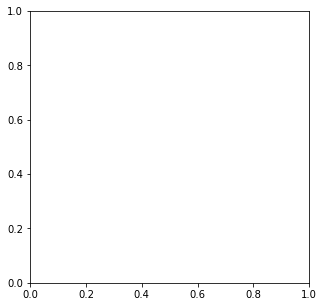

In [249]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.scatter(
    embeddingt[:, 0],
    embeddingt[:, 1],
    c=[sns.color_palette('Paired',33)[x] for x in lidxt],
    alpha=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('All averaged', fontsize=24);

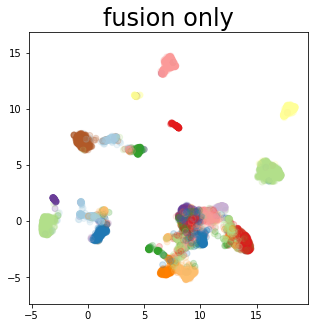

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.scatter(
    embeddingf[:, 0],
    embeddingf[:, 1],
    c=[sns.color_palette('Paired',33)[x] for x in lidx],
    alpha=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('fusion only', fontsize=24);

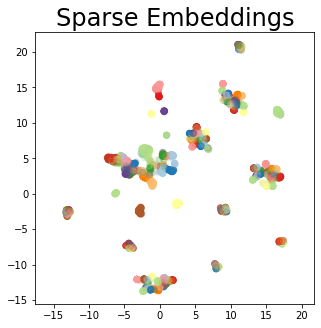

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=[sns.color_palette('Paired',33)[x] for x in lidx],
    alpha=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Sparse Embeddings', fontsize=24);

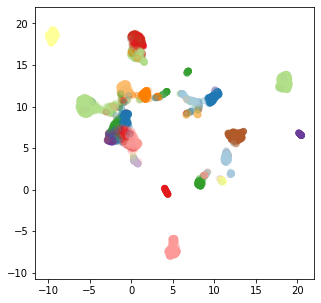

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette('Paired',33)[x] for x in lidx],
    alpha=0.2)
plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of the Penguin dataset', fontsize=24);